# Load ERA5-Land air temperature and precipitation data, save as .csv at each study site

In [1]:
import ee
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tqdm.auto import tqdm
import xarray as xr
import rioxarray as rxr

In [2]:
# -----Define paths in directory
# path to study-sites/
study_sites_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/study-sites/'

# path to snow-cover-mapping/
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

In [3]:
# -----If using Google Colab, mount Google Drive so you can access your Drive folders
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# -----Authenticate and intialize Google Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [5]:
# Uncomment and use this to locate the folder above, if needed
# os.listdir('drive/MyDrive/Research/PhD/snow_cover_mapping/snow_cover_mapping_application/study-sites/')

In [6]:
# -----Grab list of site names with snowlines and no ERA data in folder
os.chdir(study_sites_path)
site_names = sorted([x[:-1] for x in glob.glob('*/', recursive = True)])
site_names = [x for x in site_names if len(glob.glob(x + '/imagery/snowlines/*.csv')) > 0]
# Only include those without ERA data already
site_names = [x for x in site_names if len(glob.glob(x + '/ERA/*.csv'))==0]

print('Number of sites to run = ' + str(len(site_names)))
site_names

Number of sites to run = 1


['RGI60-01.10851']

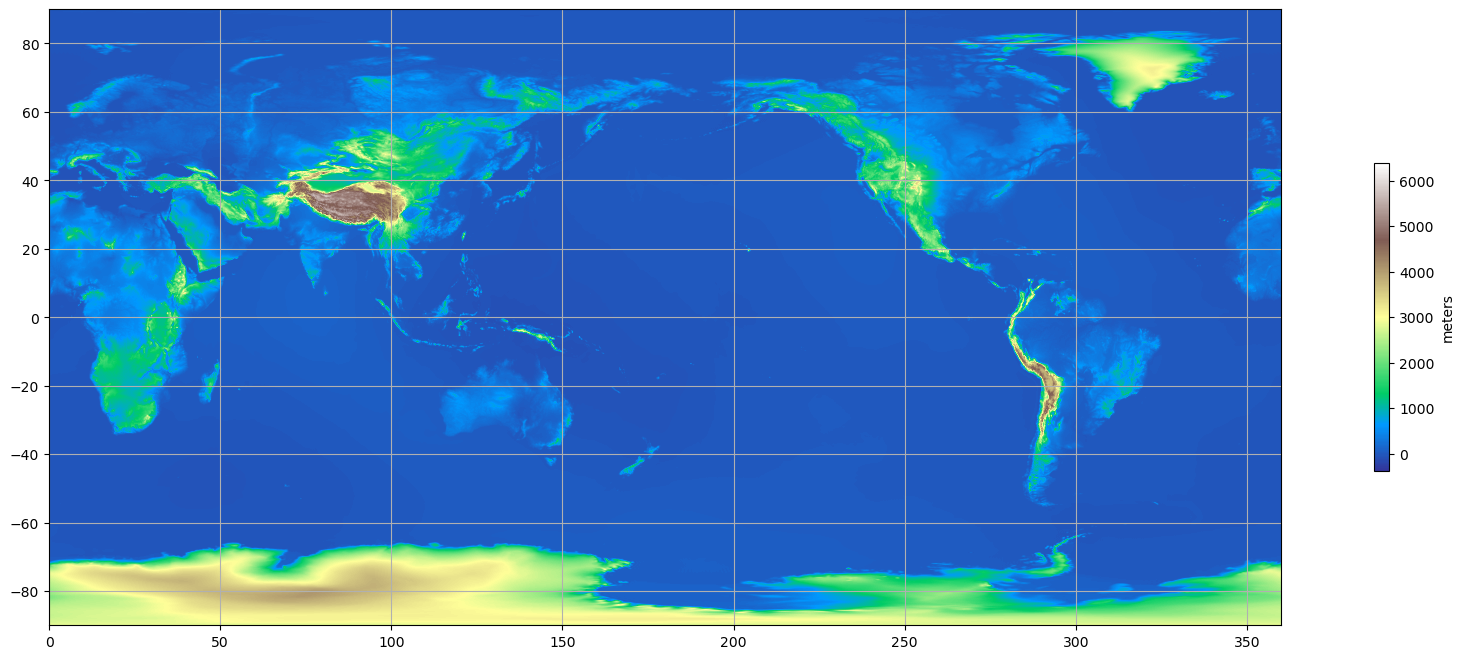

In [7]:
# -----Load ERA5-Land elevations and reference to the geoid

# Load ERA5-Land reference elevation data
era_geo_fn =  os.path.join(base_path, '..', 'snow-cover-mapping-application', 'inputs-outputs', 'geo_1279l4_0.1x0.1.grib2_v4_unpack.nc')
era_geo = xr.open_dataset(era_geo_fn)
era_geo = era_geo / 9.8
# era_geo = xr.where(era_geo<=0, np.nan, era_geo / 9.8)
# shift longitudes > 180 to longitude - 360
era_geo.longitude.values[era_geo.longitude.values>180] = era_geo.longitude.values[era_geo.longitude.values>180] - 360

# Load EGM96 geoid heights
egm96_fn = os.path.join(base_path, 'inputs-outputs', 'us_nga_egm96_15.tif')
egm96 = xr.open_dataset(egm96_fn)
# interpolate to era_geo coordinates
egm96_interp = egm96.interp(x=era_geo.longitude, y=era_geo.latitude, method='nearest')

# Subtract the geoid from ERA5-Land ellipsoid heights
era_elevs_geoid = era_geo.z.data - egm96_interp.band_data.data
era_geo['z'] = (('time', 'latitude', 'longitude'), era_elevs_geoid)
era_geo = era_geo.rio.write_crs('EPSG:4326')

# Plot elevation
plt.figure(figsize=(24,8))
plt.imshow(era_geo.z.data[0], extent=(0,360,-90,90), cmap='terrain')
plt.colorbar(label='meters', shrink=0.5)
plt.grid()
plt.show()

In [ ]:
# -----Compare DEMs to ERA5-Land elevations for a few sites
for site_name in site_names[0:5]:

    print(site_name)

    # -----Load AOI (glacier outline) and reformat
    AOI_fn = glob.glob(site_name + '/AOIs/*_outline.shp')[0]
    AOI = gpd.read_file(AOI_fn)
    # reproject to WGS84
    AOI_WGS = AOI.to_crs('EPSG:4326')
    
    # -----Load DEM
    DEM_fn = glob.glob(site_name + '/DEMs/*.tif')[0]
    if 'NASADEM' in DEM_fn:
        DEM_name = 'NASADEM'
    elif 'ArcticDEM' in DEM_fn:
        DEM_name = 'ArcticDEM'
    else:
        DEM_name = 'USGS DEM'
    DEM = xr.open_dataset(DEM_fn)
    # reproject to WGS84
    DEM = DEM.rio.reproject('EPSG:4326')
    # remove no data values
    DEM = xr.where((DEM > 1e38) or (DEM<=-9999), np.nan, DEM)
    DEM = DEM.rio.write_crs('EPSG:4326')
    # clip to AOI
    DEM_clip = DEM.rio.clip(AOI_WGS.geometry)

    
    # -----Interpolate ERA geo data to DEM coordinates
    era_geo_interp = era_geo.interp(longitude=DEM.x, latitude=DEM.y, method='linear')
    # clip to AOI
    era_geo_interp_clip = era_geo_interp.rio.clip(AOI_WGS.geometry)
    
    # -----Plot
    elev_min = np.nanmin([np.nanmin(DEM_clip.band_data.data[0]), np.nanmin(era_geo_interp_clip.z.data[0])])
    elev_max = np.nanmax([np.nanmax(DEM_clip.band_data.data[0]), np.nanmax(era_geo_interp_clip.z.data[0])])
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    dem_im = ax[0].imshow(DEM_clip.band_data.data[0], cmap='terrain', clim=(elev_min, elev_max),
                          extent=(np.min(DEM.x.data), np.max(DEM.x.data), np.min(DEM.y.data), np.max(DEM.y.data)))
    fig.colorbar(dem_im, ax=ax[0], shrink=0.5)
    ax[0].set_title(DEM_name)
    era5_im = ax[1].imshow(era_geo_interp_clip.z.data[0], cmap='terrain', clim=(elev_min, elev_max),
                           extent=(np.min(DEM.x.data), np.max(DEM.x.data), np.min(DEM.y.data), np.max(DEM.y.data)))
    fig.colorbar(era5_im, ax=ax[1], shrink=0.5)
    ax[1].set_title('ERA5-Land elevation')
    diff_im = ax[2].imshow(DEM_clip.band_data.data[0] - era_geo_interp_clip.z.data[0], cmap='Reds', 
                           extent=(np.min(DEM.x.data), np.max(DEM.x.data), np.min(DEM.y.data), np.max(DEM.y.data)))
    fig.colorbar(diff_im, ax=ax[2], shrink=0.5)
    ax[2].set_title('Difference')    
    plt.show()
    
    diff_mean = np.nanmean(np.ravel(DEM_clip.band_data.data[0]) - np.ravel(era_geo_interp_clip.z.data[0]))                                    
    print('Mean difference = ' + str(np.round(diff_mean,2)) + ' m \n')
    

In [8]:
# define function to grab mean band values over a region of interest 
def calculate_mean(image):
    
    # Select specific bands
    image = image.select(bands_of_interest)
    
    # Calculate mean for the selected bands in the ROI
    mean_values = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=1000  # Adjust the scale as needed
    )
    return image.set(mean_values)

  0%|          | 0/1 [00:00<?, ?it/s]

RGI60-01.10851
Made directory for output files
ERA5-Land data variables saved to file: RGI60-01.10851/ERA/RGI60-01.10851_ERA5-Land_2012-11-01_2023-11-01.csv


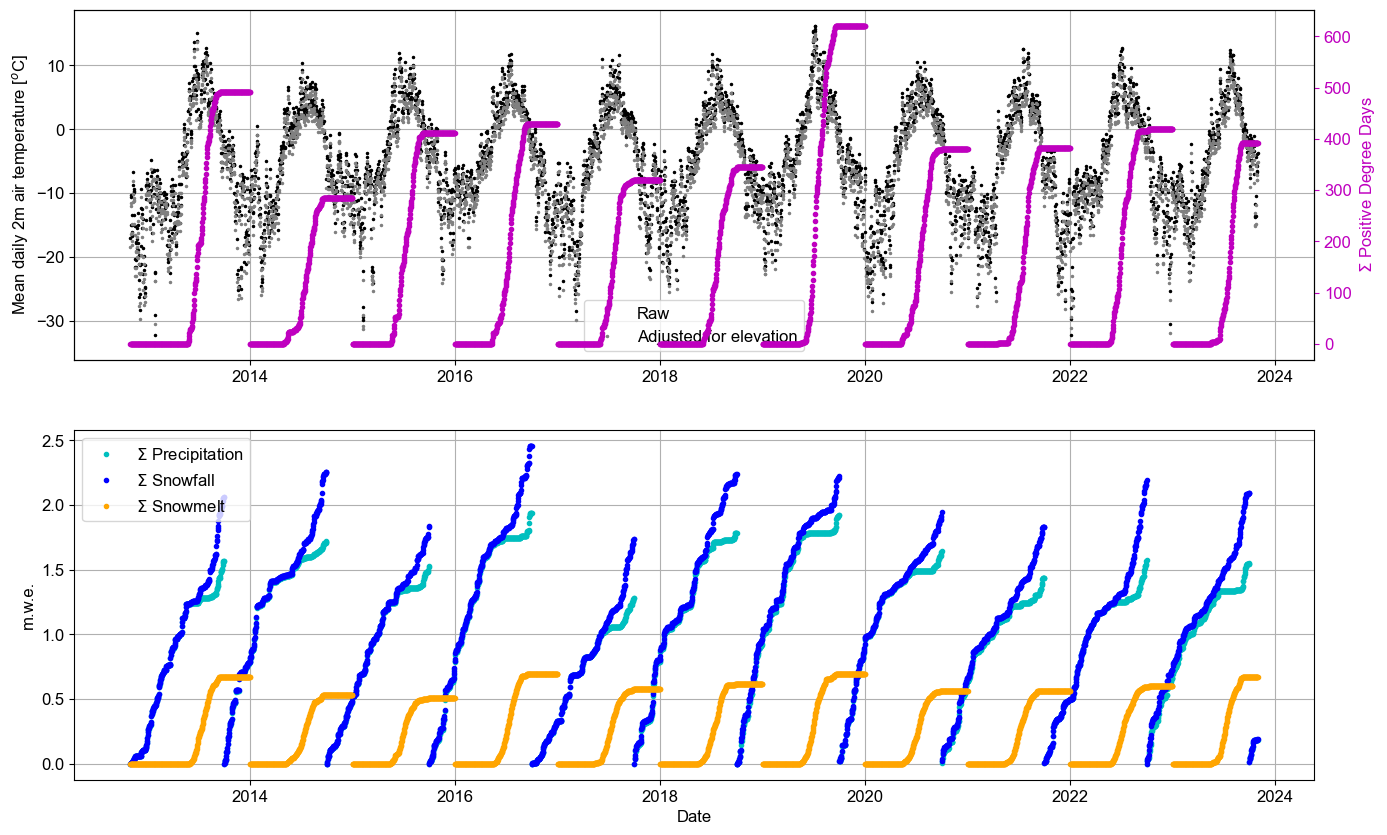

figure saved to file:  RGI60-01.10851/ERA/RGI60-01.10851_ERA5-Land_2012-11-01_2023-11-01.png
 


In [9]:
# Define date range for ERA5 querying
date_start = '2012-11-01'
date_end = '2023-11-01'

# define bands to extract from ERA5-Land
bands_of_interest = ['temperature_2m', 
                     'total_precipitation_sum', 
                     'snowfall_sum', 
                     'snowmelt_sum'] 

# define lapse rate to apply to air temperatures
lapse_rate = 6 # deg C / km

# adjust plot parameters
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})

# Iterate over study sites
for site_name in tqdm(site_names):

    print(site_name)

    # check if output directory exists
    out_path = os.path.join(site_name, 'ERA')
    if not os.path.exists(out_path):
        os.mkdir(out_path)
        print('Made directory for output files')
    
    # check if file already exists in directory
    output_fn = os.path.join(out_path, site_name + '_ERA5-Land_' + date_start + '_' + date_end + '.csv')
    if os.path.exists(output_fn):
        print('ERA5-Land CSV for these dates already exists in file, continuing... \n')
        continue

    # -----Load AOI (glacier outline) and reformat
    AOI_fn = glob.glob(os.path.join(site_name, 'AOIs', '*_outline.shp'))[0]
    AOI = gpd.read_file(AOI_fn)
    # reproject to WGS84
    AOI_WGS = AOI.to_crs('EPSG:4326')
    # Reformat AOI for GEE querying
    region = ee.Geometry.Polygon([[[AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.miny[0]],
                                  [AOI_WGS.geometry.bounds.maxx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.maxy[0]],
                                  [AOI_WGS.geometry.bounds.minx[0], AOI_WGS.geometry.bounds.miny[0]]
                                  ]])
    
    # -----Load DEM
    if not os.path.exists(os.path.join(site_name, 'DEMs')):
        print('No DEM in file, skipping...')
        continue
    DEM_fns = glob.glob(os.path.join(site_name, 'DEMs', '*.tif'))
    if len(DEM_fns) < 1:
        print('No DEM in file, skipping...')
        continue
    if 'NASADEM' in DEM_fns[0]:
        DEM_fn = DEM_fns[0]
    elif 'ArcticDEM' in DEM_fns[0]:
        DEM_fn = glob.glob(site_name + '/DEMs/*_geoid.tif')[0]
    elif 'USGS' in DEM_fns[0]:
        DEM_fn = glob.glob(site_name + '/DEMs/*USGS*_geoid.tif')[0]
    DEM = xr.open_dataset(DEM_fn)
    # reproject to WGS84
    DEM = DEM.rio.reproject('EPSG:4326')
    # remove no data values
    DEM = xr.where((DEM > 1e38) or (DEM<=-9999), np.nan, DEM)
    DEM = DEM.rio.write_crs('EPSG:4326')
    # clip to AOI
    DEM_clip = DEM.rio.clip(AOI_WGS.geometry)
    # calculate mean elevation
    elev_mean_DEM = np.nanmean(np.ravel(DEM_clip.band_data.data[0]))
    
    # -----Grab ERA5-Land elevation at AOI
    # interpolate to DEM coordinates
    era_geo_interp = era_geo.interp(longitude=DEM.x, latitude=DEM.y, method='linear')
    # clip to AOI
    era_geo_interp_clip = era_geo_interp.rio.clip(AOI_WGS.geometry)
    # calculate mean elevation
    elev_mean_era = np.nanmean(np.ravel(era_geo_interp_clip.z.data[0]))

    # -----Define the dataset
    era5_land = (ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR")
                 .filter(ee.Filter.date(date_start, date_end))
                 .filterBounds(region)
                )
    
    # -----Apply the calculate_mean function to each image in the collection
    era5_land_mean = era5_land.map(calculate_mean)

    # -----Compile statistics into DataFrame
    # ceate empty lists to store the data
    dates = []
    mean_values_list = {band: [] for band in bands_of_interest}
    # iterate over the ImageCollection to collect data
    for image in era5_land_mean.getInfo()['features']:
        date = pd.to_datetime(image['properties']['system:time_start'], unit='ms')  # Convert to datetime
        dates.append(date)

        mean_values = image['properties']
        for band in bands_of_interest:
            mean_values_list[band].append(mean_values[band])
    # create a Pandas DataFrame
    data = {'Date': dates}
    data.update(mean_values_list)
    df = pd.DataFrame(data)
    
    # -----Convert air temperatures to Celsius (from Kelvin)
    df['Temperature_Celsius'] = df['temperature_2m'] - 273.15

    # -----Adjust air temperatures using reference elevations and lapse rate
    df['Temperature_Celsius_Adjusted'] = df['Temperature_Celsius'] - lapse_rate * (elev_mean_DEM - elev_mean_era)/1e3
    
    # -----Add cumulative positive degree days
    # Calculate Positive Degree Days (PDDs)
    df['Positive_Degree_Days'] = df['Temperature_Celsius_Adjusted'].apply(lambda x: max(0, x))
    # Calculate cumulative sum and reset at the start of each calendar year
    df['Cumulative_Positive_Degree_Days'] = df.groupby(df['Date'].dt.year, group_keys=True)['Positive_Degree_Days'].cumsum()
    # Reset cumulative sum to zero at the start of each year
    df['Cumulative_Positive_Degree_Days'] = df.groupby(df['Date'].dt.year, group_keys=False)['Cumulative_Positive_Degree_Days'].apply(lambda x: x - x.iloc[0])
    
    # -----Add cumulative annual precipitation, snowfall, and snowmelt
    # precipitation and snowfall: calculate for the water year
    df['Water_Year'] = df['Date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1) # add a water year column
    df['Cumulative_Precipitation_mwe'] = df.groupby('Water_Year')['snowfall_sum'].cumsum()    
    df['Cumulative_Snowfall_mwe'] = df.groupby('Water_Year')['total_precipitation_sum'].cumsum()   
    # snowmelt: calculate for the calendar year
    df['Cumulative_Snowmelt_mwe'] = df.groupby(df['Date'].dt.year)['snowmelt_sum'].cumsum()
    
    # -----Prepare DataFrame for saving
    # Rename columns
    df = df.rename(columns = {'total_precipitation_sum' : 'Precipitation_Meters', 
                              'snowfall_sum' : 'Snowfall_mwe',
                              'snowmelt_sum' : 'Snowmelt_mwe'})
    # Reorder columns
    df = df[['Date', 
             'Temperature_Celsius',
             'Temperature_Celsius_Adjusted',
             'Precipitation_Meters',
             'Cumulative_Precipitation_mwe',
             'Snowfall_mwe',
             'Cumulative_Snowfall_mwe',
             'Snowmelt_mwe',
             'Cumulative_Snowmelt_mwe',
             'Positive_Degree_Days', 
             'Cumulative_Positive_Degree_Days']]
    # Save DataFrame to CSV
    df.to_csv(output_fn, index=False)
    print('ERA5-Land data variables saved to file: ' + output_fn)

    # -----Plot data variables
    fig, ax = plt.subplots(2, 1, figsize=(16,10))
    # daily air temp
    ax[0].plot(df.Date.values.astype('datetime64[ns]'), df['Temperature_Celsius'].values, 
               '.k', markersize=3, label='Raw')
    ax[0].plot(df.Date.values.astype('datetime64[ns]'), df['Temperature_Celsius_Adjusted'].values, 
               '.', color='Gray', markersize=3, label='Adjusted for elevation')
    ax[0].set_ylabel('Mean daily 2m air temperature [$^o$C]')
    ax[0].legend(loc='best')
    ax[0].grid()
    # Cumulative positive degree days
    ax0 = ax[0].twinx()
    ax0.plot(df.Date.values.astype('datetime64[ns]'), df.Cumulative_Positive_Degree_Days, '.m', label='Cumulative PDDs')
    ax0.set_ylabel('$\Sigma$ Positive Degree Days', color='m')
    ax0.tick_params(axis='y', colors='m')
    # precip
    ax[1].plot(df.Date.values.astype('datetime64[ns]'), df.Cumulative_Precipitation_mwe, '.c', label='$\Sigma$ Precipitation')
    # snowfall and snowmelt
    ax[1].plot(df.Date.values.astype('datetime64[ns]'), df.Cumulative_Snowfall_mwe, '.b', label='$\Sigma$ Snowfall')
    ax[1].plot(df.Date.values.astype('datetime64[ns]'), df.Cumulative_Snowmelt_mwe, '.', color='orange', label='$\Sigma$ Snowmelt')
    ax[1].grid(True)
    ax[1].legend()
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('m.w.e.')
    plt.show()

    # save figure
    fig_fn = os.path.join(out_path, site_name + '_ERA5-Land_' + date_start + '_' + date_end + '.png')
    fig.savefig(fig_fn, dpi=300)
    print('figure saved to file: ', fig_fn)
    
    print(' ')
